In [24]:
import sys
sys.path.append('../') # To import from parent dir
import time
import os
import ast

import pandas as pd
import numpy as np
from itertools import chain

import util.GrammarBasedUtil as grammar_util
import util.ui_stump as ui_stump

import matplotlib.pyplot as plt

In [25]:
# ---- Define if you want to process a sample Smart RPA Log ----
# Set True if a smartRPALog should be processed
# If false set leno_plus as well
isSmartRPA = True
log_name_smartRPA = "LenLog_1_1_10_15_1_15000.csv"

# ---- Leno Sequential Log ----
# Choose Leno Pluse = True for SR RT ordered first all Student Records afterwars Reimbursement
# If leno_plus = False they are mixed: One SR One RT One SR and so forth
leno_plus = False


#       ####                                        ####
#       ####                                        ####
#       ####                                        ####
#       ####    After Setting the top parameters    ####
#       ####    you can start all cells with the    ####
#       ####    Notebook function ">> Run All".     ####
#       ####                                        ####
#       ####                                        ####
#
#       ####                                        ####
#       ####                                        ####

Setup of Data and reading of necessary files for SmartRPA validation

In [26]:
# ---- Initialize all context parameters that will be used ----
# ---- Define the path in which all files are stored ----
folder_path_smartRPA = "../logs/smartRPA/percentageComparison/"
percentagData_filename = "validationDataPercentage.csv"

folder_path_leno = "../logs/leno/"
sep_leno = ";"

# ---- Getting the relevant files from the folder and sorting them into different lists for processing ----
sep_smartrpa = ","
percentageLogs = []

for file in os.listdir(folder_path_smartRPA):
    if file.startswith("LenLog"):
        percentageLogs.append(file)

# Check if data created for percentage based comparison is available
try:
    percentageValData = pd.read_csv(folder_path_smartRPA + percentagData_filename)
    percentageValAvailable = True
except FileNotFoundError as e:
    print(f"Could not read {percentagData_filename} from the folder.\n{e}")
    percentageValAvailable = False

Encoding of unique subsequences - Counting their overall occurances in the log

In [27]:
# Create Standard Based data for both logs, so that all down stream measures look the same

# 1. Dataframe mit Start Index, Length, End_Index
# 2. Context Parameters
#   2.2. All levels initiated
#   2.1. Flatten hierarchy_columns
# 3. Read Files

if isSmartRPA:
    # Note: Read the alignment hints above
    systems = ["category"]
    applications = ["application"]
    uiGroup1 = ["workbook","browser_url","title"]
    uiGroup2 = ["current_worksheet"] 
    uiGroup3 = ["cell_range","cell_range_number"]
    uiElement = ["mouse_coord","tag_category","xpath","event_src_path","event_dest_path","tag_name","tag_title","tag_href",
                "tag_innerText","tab_pinned","tab_audible","tab_muted","window_ingognito","tab_moved_from_index","tab_moved_to_index","id"]
    actions = ["concept:name","eventQual"]
    # ---- Add all hierarchy levels into a list ----
    hierarchy_list_smartrpa = [systems, applications, uiGroup1, uiGroup2, uiGroup3, uiElement, actions]
    hierarchy_columns_smartrpa = list(chain.from_iterable([h for h in hierarchy_list_smartrpa if h]))

    hierarchy_list = hierarchy_list_smartrpa
    hierarchy_columns = hierarchy_columns_smartrpa
    
    file = pd.read_csv(folder_path_smartRPA + log_name_smartRPA, sep=sep_smartrpa)
    log = grammar_util.symbolize_UILog(file, hierarchy_columns)
    print(f"Processing file: {log_name_smartRPA} with {len(log)} events.")
    comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log_name_smartRPA]
    insertSpots = comparisonVariables["motifSpots"]
    parsed_spots = insertSpots.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    insert_spots_flat = [int(i) for sublist in parsed_spots for i in sublist]
    insert_spots_set = set(insert_spots_flat)
    print(f"{len(insert_spots_set)} insertion spots.")
    columns = ["caseid", "start_index", "length", "end_index"]
    ground_truth = pd.DataFrame(columns=columns)
    i = 0
    for insert_spot in insert_spots_set:
        ground_truth.loc[len(ground_truth)] = [i, insert_spot, comparisonVariables["motifLength"].iloc[0], insert_spot + comparisonVariables["motifLength"].iloc[0]]
        i += 1
else:
    systems = []
    applications = ["targetApp"]
    uiGroup1 = ["url","target.workbookName"]
    uiGroup2 = ["target.sheetName"]
    uiElement = ["target.id","target.tagName","target.type","target.name","target.href"]
    actions = ["eventType"]
    hierarchy_list_leno = [applications, uiGroup1, uiGroup2, uiElement, actions]
    # Flatten the hierarchy list and remove empty lists
    hierarchy_list = hierarchy_list_leno
    hierarchy_columns = list(chain.from_iterable([h for h in hierarchy_list_leno if h]))
    if leno_plus: # Leno Log Sequential
        leno_SR_RT_plus = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus.csv", sep=sep_leno)
        leno_SR_RT_plus_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus_ground_truth.csv")
        insert_spots_set_SR_RT_plus = leno_SR_RT_plus_ground_truth["start_index"].astype(int).tolist()
        leno_SR_RT_plus_ground_truth["end_index"] = 0
        leno_SR_RT_plus_ground_truth["end_index"] = leno_SR_RT_plus_ground_truth["start_index"] + leno_SR_RT_plus_ground_truth["length"]
        ground_truth = leno_SR_RT_plus_ground_truth
        log = grammar_util.symbolize_UILog(leno_SR_RT_plus, hierarchy_columns)
    else: # Leno Log Parallel
        leno_SR_RT_parallel = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel.csv", sep=sep_leno)
        leno_SR_RT_parallel_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel_ground_truth.csv")
        insert_spots_set_SR_RT_parallel = leno_SR_RT_parallel_ground_truth["start_index"].astype(int).tolist()
        leno_SR_RT_parallel_ground_truth["end_index"] = 0
        leno_SR_RT_parallel_ground_truth["end_index"] = leno_SR_RT_parallel_ground_truth["start_index"] + leno_SR_RT_parallel_ground_truth["length"]
        ground_truth = leno_SR_RT_parallel_ground_truth
        log = grammar_util.symbolize_UILog(leno_SR_RT_parallel, hierarchy_columns)

Processing file: LenLog_1_1_10_15_1_15000.csv with 15000 events.
10 insertion spots.


In [28]:
# ---- Time the original implementation ----
encoding_df, symbols, two_gram_df = grammar_util.re_pair(log)
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Encoded Entry: ",last_encoding)
decoded_symbol = grammar_util.re_pair_decode_symbol(last_encoding, encoding_df, printing=True)

445  unique pairs found so far. Level:  1
454  unique pairs found so far. Level:  2
458  unique pairs found so far. Level:  3
460  unique pairs found so far. Level:  4
461  unique pairs found so far. Level:  5

 Last Encoded Entry:  qs
qs → (qq, qf)
  qq → (qm, qo)
    qm → (q, qd)
      q → (JGE, JGG)
        JGE → [base symbol]
        JGG → [base symbol]
      qd → (o, m)
        o → (JQA, JGF)
          JQA → [base symbol]
          JGF → [base symbol]
        m → (IZH, JRA)
          IZH → [base symbol]
          JRA → [base symbol]
    qo → (e, qh)
      e → (JQX, IVT)
        JQX → [base symbol]
        IVT → [base symbol]
      qh → (IUK, i)
        IUK → [base symbol]
        i → (ITB, JCW)
          ITB → [base symbol]
          JCW → [base symbol]
  qf → (g, d)
    g → (ITB, JGG)
      ITB → [base symbol]
      JGG → [base symbol]
    d → (JQU, IZI)
      JQU → [base symbol]
      IZI → [base symbol]

Decoding path for symbol 'qs':
Final expansion: ['JGE', 'JGG', 'JQA', 'JGF

Exec. Time with loops: 5.054 seconds
8960


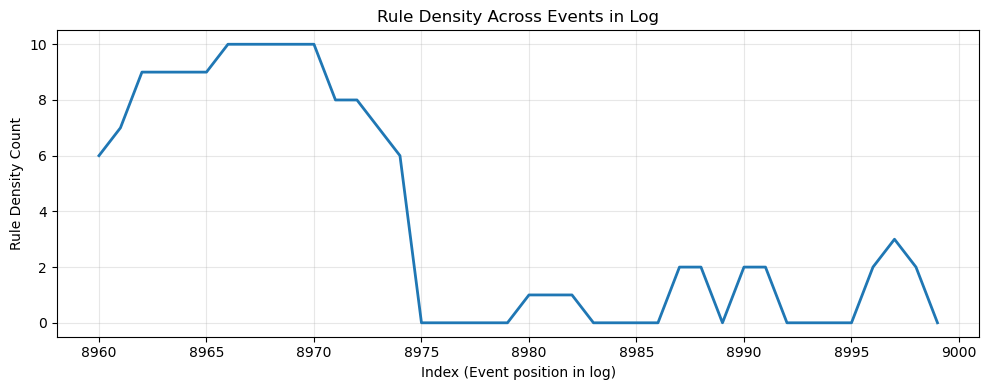

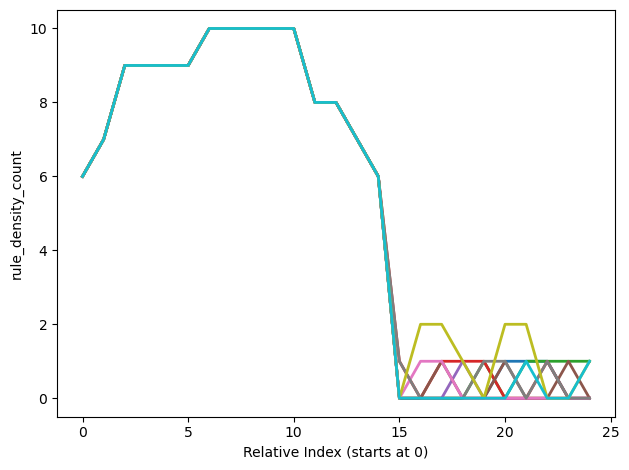

In [29]:
# Initialize the count column
start_time = time.time()
log = grammar_util.generate_density_count(encoding_df, log)
end_time = time.time()
print(f"Exec. Time with loops: {end_time - start_time:.3f} seconds")
motiv = int(ground_truth.iloc[0]["start_index"])
print(motiv)
grammar_util.plot_density_curve(log, range_low=motiv, range_high=motiv+40)

colors = plt.cm.tab10.colors
length = ground_truth["length"].max()
for i, start in enumerate(ground_truth["start_index"]):
    end = start+length+10
    y = log.iloc[start:end]["rule_density_count"].to_numpy()
    x = range(len(y))  # all start at 0
    plt.plot(x, y, color=colors[i % len(colors)], linewidth=2, label=f"Range {start}-{end}")

plt.xlabel("Relative Index (starts at 0)")
plt.ylabel("rule_density_count")
plt.tight_layout()
plt.show()

Maximum rule density count: 10
Longest identified motif length: 9

intersection_ratio: 1.000
intersection_abs: 9.000
undercount_ratio: 0.438
undercount_abs: 7.000
over_detection_ratio: 0.000
over_detection_abs: 0.000

Precision: 1.000, Recall: 1.000, F1: 1.000


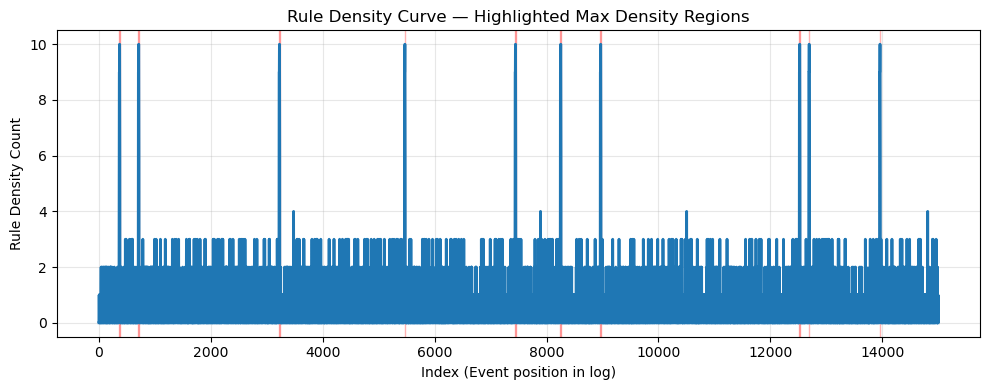

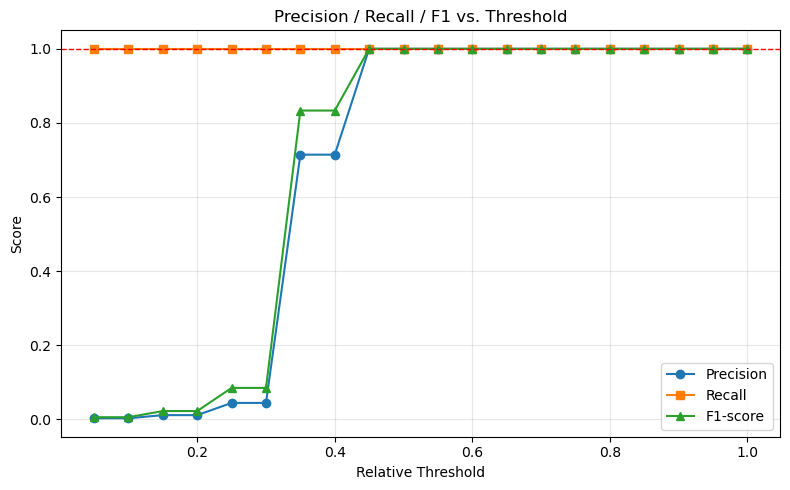

In [30]:
max_rule_density_count, max_groups = grammar_util.find_max_density_groups(log,relative_threshold=0.9)

print(f"Maximum rule density count: {max_rule_density_count}")
max_length = -1
min_length = len(log)
for motif in max_groups:
    if len(motif) > max_length:
        max_length = len(motif)
    if len(motif) > 0 and len(motif) < min_length:
        min_length = len(motif)
print(f"Longest identified motif length: {max_length}\n")

# >> Wie finden wir jetzt von diesem Punkt aus die richtige Länge an Motifen im Datensatz? 
# Die Punkte haben wir

# Return Sample:
# [{'insert_range': (54.0, 85.0), 'density_range': (77, 81)},
#  {'insert_range': (164.0, 195.0), 'density_range': (187, 191)},
overlaps = grammar_util.find_overlaps(max_groups, ground_truth)


stats = grammar_util.motif_overlap_metrics(max_groups, ground_truth)
for key, value in stats.items():
    print(f"{key}: {value:.3f}")

# Version with over counting as two overlaps could span a single ground truth
# Especially occurring with longer motifs
tp = len(overlaps)                      # true positives = overlapping ranges
fp = len(max_groups) - tp               # predicted but not in ground truth
fn = len(ground_truth) - tp             # missed ground truth ranges

matched, tp, fp, fn, gt1 = grammar_util.match_motifs_to_gt(max_groups, ground_truth)

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


# ---- Plotting the results ----
plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in max_groups:
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Rule Density Curve — Highlighted Max Density Regions")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

grammar_util.test_multi_threshold_scores(ground_truth,log)

## Valmod Development based on GrammarViz Seeds Identified

In [31]:
# Timeseries

t = log             # Time Series aka UI log
max_groups          # Seeds for VALMOD aka high density count of grammar rules
m0 = lmin = min_length   # Min length for to be discovered motifs > Could be set as min lenght in max_groups
lmax = None         # Max length for the to be discovered motifs > Should be empty
p = 10              # Carry over candidates for the discovery of motifs in the VALMOD circles

ex_zone = None      # Set an exclusion zone in activities that the motif is not allowed to have other motifs around, usually motif/2

In [46]:
# Prune the max_groups if they come from the same set of rules, aka they are already the same motifs
# >> Remove duplicate motifs ahead of time as these then are already motifs, but might be short

filtered_rule_based_motifs = grammar_util.remove_redundant_groups(max_groups, log)
 # First Index of the occurance
print(filtered_rule_based_motifs)

                                        sequence  occurrence  \
0  [JQA, JGF, IZH, JRA, JQX, IVT, IUK, ITB, JCW]          10   

                                first_occurrence  
0  [362, 363, 364, 365, 366, 367, 368, 369, 370]  


In [47]:
paths = ui_stump.build_paths_from_df(file, hierarchy_list)
symbol_of_path, levels = ui_stump.build_levels_table(paths, n=len(hierarchy_list))
T_ids = ui_stump.encode_series(paths, symbol_of_path)
weights = ui_stump.hierarchy_weights(len(hierarchy_list))
C = ui_stump.build_cost_matrix(levels, weights)  # shape (V, V)

# Has to be executed for each seed from the filtered_rule_based_motifs
for seed in filtered_rule_based_motifs:
    s0 = filtered_rule_based_motifs["first_occurrence"][0][0]
    mp = ui_stump.stump(T_ids, levels, weights, m=min_length, ignore_trivial=True, k=p)      # hierarchy-aware MP
    cand_idx = mp.I_[s0][:p]                           # candidate offsets for i = s0
    cand_dist = mp.P_[s0][:p].astype(float)            # their distances (avg UI distance)

In [48]:
def nontrivial_neighbors(I_row, m, i, min_sep=None):
    """Filter out trivial matches closer than one window length."""
    if min_sep is None:
        min_sep = m
    return [j for j in I_row if abs(j - i) >= min_sep]

cand_idx = nontrivial_neighbors(mp.I_[s0], m0, s0)[:p]

In [49]:
cand_idx

[12524, 12693, 13959, 12519, 12688, 13954, 12517, 12520, 12689, 13955]